# Detectiondottir
## v3, the sliding window Santorini version


### Imports

In [2]:
import sys
sys.path.insert(1, '/Users/saraklaasen/Documents/Work/git/das_templates/pydas_readers/readers')
sys.path.insert(1, '/Users/saraklaasen/Documents/Work/git/das_templates/pydas_readers/util')
sys.path.insert(1, '/Users/saraklaasen/Documents/Work/Grimsvötn/scripts')
from load_das_h5 import *
from processing import *
from block_filters import *
import glob, os

import numpy as np
import cv2 as cv
from typing import Union
import pathlib
import datetime
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from obspy.signal.trigger import classic_sta_lta

from skimage.color import rgba2rgb
from skimage import io
from skimage.filters import threshold_multiotsu
from skimage.morphology import remove_small_objects
from skimage.color import rgb2gray
from scipy.ndimage.filters import gaussian_filter

In [1]:
#functions to open decimated Santorini data

def open_1file(file, t0=0, t1=-1, channel0=0, channel1=-1, fs=40):
    name = os.path.basename(file)
    t = datetime.datetime.strptime(name, 'S_25ms_%Y%m%d_%H%M%S.%f.h5')
    if type(t0) == datetime.datetime:
        dt = t0 - t
        dt *= fs
        t0 = dt.seconds
        
    if type(t1) == datetime.datetime:
        dt = t1 - t
        dt *= fs
        t1 = dt.seconds
        
    hf = h5py.File(file, 'r')
    data = hf['Traces'][t0:t1, channel0:channel1]
    
    return data.T


def open_data(flist, t0, t1, channel0=0, channel1=-1, fs=40):
    """
    function to open data
    flist: list of files in data directory
    t0: desired start time, datetime object
    t1: desired end time, datetime object
    channel0: desired start channel, int
    channel1: desired end channel, int
    fs: sampling rate, int
    """
    # create list of datetime objects of all starting times of files in one directory
    t = []
    for i in range(len(flist)):
        name = os.path.basename(flist[i])
        t.append(datetime.datetime.strptime(name, 'S_25ms_%Y%m%d_%H%M%S.%f.h5'))
    
    # find which files correspond to the given start and end times
    near1 = min(t, key=lambda x: abs(x - t0))
    near2 = min(t, key=lambda x: abs(x - t1))
    
    if t0 > near1:
        f1 = t.index(near1) 
    else:
        f1 = t.index(near1) - 1
    if t1 > near2:
        f2 = t.index(near2) + 1
    else:
        f2 = t.index(near2)
    
    # open data from only 1 file
    if f2-f1 == 1:
        data = open_1file(flist[f1], t0=t0, t1=t1, channel0=channel0, channel1=channel1, fs=fs)
   
    # open data from multiple files, and concatenate into one numpy array
    else:
        for i in range(f2-f1):
            if i == 0:
                data = open_1file(flist[i], t0=t0, channel0=channel0, channel1=channel1, fs=fs)
            elif i < f2-f1-1:
                data0 = open_1file(flist[i], channel0=channel0, channel1=channel1, fs=fs)
                data = np.concatenate((data, data0), axis=1)
            elif i == f2-f1-1:
                data0 = open_1file(flist[i], t1=t1, channel0=channel0, channel1=channel1, fs=fs)
                data = np.concatenate((data, data0), axis=1)
            else:
                print('something went wrong')
    
    
    return data

In [3]:
flist = sorted(glob.glob('./*.h5'))

fs = 40

channel0 = 1600
channel1 = 4100
t0 = datetime.datetime(2021, 10, 19, 12, 32, 30)
t1 = datetime.datetime(2021, 10, 19, 12, 33, 0)

d = open_data(flist, t0, t1, channel0=channel0, channel1=channel1)

## parameters

In [19]:
read_in_extra_s = 3
taper_fraction = 0.01
freq_low = 1
freq_high = 19
decimate_factor1 = 5
decimate_factor2 = 4
n_channels_stack = 4
exponent_stack = 2
sta = 25
lta = 150
classes = 4
kernel_horizontal = 500
kernel_vertical = 1000
kernel_diagonal = 15
cluster_size1 = 64#1e3
cluster_size2 = 5e3#1e5
window_size = 30
window_dt = lta

## functions

In [20]:
def phase_stack(d, ns, exp):
    # ns: Number of traces to stack left and right of the central trace.
    d_stack = np.zeros(np.shape(d))
    nx = d.shape[0]-1
    # Move through the record section.
    for i in range(ns,nx-ns-1):
        # Compute phase weight.
        dh=hilbert(d[i-ns:i+ns+1,:],axis=1)
        pw=np.sum(dh/np.abs(dh),axis=0)
        pw/=np.max(np.abs(pw))
        # Compute phase-weighted stack.
        d_stack[i,:]=np.real(pw**exp * np.sum(d[i-ns:i+ns+1,:],axis=0)/float(2.0*ns+1.0))
    return d_stack

def sta_lta(a, nsta, nlta):
    """
    sta/lta function
    a: numpy array of data (channels as rows)
    nsta: int, short window
    nlta: int, long window
    """
    # The cumulative sum can be exploited to calculate a moving average (the
    # cumsum function is quite efficient)
    sta = np.cumsum(a ** 2, axis=1)

    # Convert to float
    sta = np.require(sta, dtype=float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[:,nsta:] = sta[:,nsta:] - sta[:,:-nsta]
    sta /= nsta
    lta[:,nlta:] = lta[:,nlta:] - lta[:,:-nlta]
    lta /= nlta

    # Pad zeros
    sta[:,:nlta - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

def threshold(d, classes=classes):
    thresholds = threshold_multiotsu(d, classes=classes)

    d = np.where(d < thresholds[classes-2], False, True)
    return d

def remove_horizontal_lines(kernel_size, image: np.ndarray) -> np.ndarray:
    horizontal = np.copy(image).astype(np.float32)

    horizontalStructure = cv.getStructuringElement(
        cv.MORPH_RECT, (kernel_size, 1)
    )

    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)

    return np.clip(image.astype(np.float32) - horizontal, 0, 1)

def remove_vertical_lines(kernel_size, image: np.ndarray) -> np.ndarray:
    vertical = np.copy(image).astype(np.float32)

    verticalStructure = cv.getStructuringElement(
        cv.MORPH_RECT, (1, kernel_size)
    )

    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)

    return np.clip(image - vertical, 0, 1)

def diagonal_lines(kernel_size, image: np.ndarray) -> np.ndarray:
    diagonal1 = np.copy(image).astype(np.float32)
    diagonal2 = np.copy(image).astype(np.float32)
    

    kernel = np.zeros((kernel_size, kernel_size), np.uint8)
    np.fill_diagonal(kernel, 1)
    
    kernel2 = np.flip(kernel.copy(), axis=1)

    diagonal1 = cv.erode(diagonal1, kernel)
    diagonal1 = cv.dilate(diagonal1, kernel)

    diagonal2 = cv.erode(diagonal2, kernel2)
    diagonal2 = cv.dilate(diagonal2, kernel2)
    
    diagonal1 = np.clip(diagonal1, 0, 1)
    diagonal2 = np.clip(diagonal2, 0, 1)
    
    return np.clip(diagonal1+diagonal2, 0, 1)

# sliding window version

In [37]:
fdir = '/Users/saraklaasen/Documents/Work/santorini/data/20211019/'



d_start = 0
d_end = 44224
t1 = datetime.datetime(2021, 10, 19, 5, 17, 0)


trigger = False

time_start = []
time_end = []
channel_start = []
channel_end = []

fs = 40

channel0 = 0
channel1 = -1
t0 = datetime.datetime(2021, 10, 26, 0, 0, 30)
t1 = datetime.datetime(2021, 10, 26, 0, 1, 0)


for i in range(18):
    t1 += datetime.timedelta(seconds=window_size)
    t2 = t1 + datetime.timedelta(seconds=window_size)
    t0 = t1 - datetime.timedelta(seconds=read_in_extra_s)

    # open data
    #d, meta = load_das_custom(t0, t2, d_start=d_start, d_end=d_end, input_dir=fdir, return_axis=False)
    #d = d.T
    #fs = meta['fs']
    d = open_data(flist, t0, t2, channel0=channel0, channel1=channel1)
    
    # standard processing flow: detrend, taper, filter (decimate)
    d = detrend(d)
    d = taper(d, taper_fraction)
    d = block_bandpass(d.T, freq_low, freq_high, fs)
    #d = chebychev_lowpass_downsamp(d, fs, decimate_factor1)
    #fs /= decimate_factor1
    #d = chebychev_lowpass_downsamp(d, fs, decimate_factor2)
    #fs /= decimate_factor2
    d = d.T
    
    # further processing: phase weighted stack & sta/lta
    d = sta_lta(d, sta, lta)

    
    # image processing
    d = threshold(d)
    d = remove_horizontal_lines(kernel_horizontal, image=d.astype(bool))
    d = remove_vertical_lines(kernel_vertical, image=d.astype(bool))
    d = diagonal_lines(kernel_diagonal, image=d.astype(bool))
    d = remove_small_objects(d.astype(bool), min_size=cluster_size2)
    
    
    
    # if there are any True pixels: sliding window
    if np.any(d) == True:
        for ii in range(d.shape[1]):
            id1 = ii
            id2 = ii + window_dt
            window = d[:,id1:id2].copy()
            
            if trigger == False and np.any(window) == True:
                
                detection_start = ii + window_dt-1
                detection_start = t0 + datetime.timedelta(seconds=detection_start/fs)
                
                channel1= np.min(np.where(window == True)[0])
                channel2 = np.max(np.where(window == True)[0])
                
                trigger = True
                time_start.append(detection_start)
                
            if trigger == True and np.any(window) == True:
                
                if np.min(np.where(window == True)[0]) < channel1:
                    channel1 = np.min(np.where(window == True)[0])
                    
                if np.max(np.where(window == True)[0]) > channel2:
                    channel2 = np.max(np.where(window == True)[0])
            
            if trigger == True and np.any(window) == False:
                
                detection_end = ii
                detection_end = t0 + datetime.timedelta(seconds=detection_end/fs)
                
                trigger = False
                time_end.append(detection_end)
                channel_start.append(channel1)
                channel_end.append(channel2)
                                
            
    #break
    
    

### results

In [16]:
flist = sorted(glob.glob('/Volumes/SWP-DAS/Santorini_25ms/*'))

flist[0]

'/Volumes/SWP-DAS/Santorini_25ms/S_25ms_20211020_000012.140.h5'

In [39]:
for i in range(len(time_start)):
    t0 = time_start[i] - datetime.timedelta(seconds=2)
    t1 = time_end[i] + datetime.timedelta(seconds=2)
    d_start = channel_start[i]*8 - 50
    d_end = channel_end[i]*8 + 50
    #d, meta = load_das_custom(t0, t1, d_start=d_start, d_end=d_end, input_dir=fdir, return_axis=False)
    #d = d.T
    #fs = meta['fs']
    d = open_data(flist, t0, t1, channel0=channel_start[i], channel1=channel_end[i])
    
    fig = plt.figure(dpi=300)
    im = plt.imshow(d, cmap='seismic', aspect='auto', origin='lower', vmin=-200, vmax=200, extent=(0, (t1-t0).seconds, d_start/1000, d_end/1000))
    fig.colorbar(im)
    plt.show()

# Step-by-step

In [23]:
fdir = '/Users/saraklaasen/Documents/Work/santorini/data/20211019/'

d_start = 0
d_end = 44224
t0 = datetime.datetime(2021, 10, 19, 12, 32, 25)
t1 = datetime.datetime(2021, 10, 19, 12, 33, 5)
#t0 = datetime.datetime(2021, 10, 19, 12, 34, 0)
#t1 = datetime.datetime(2021, 10, 19, 12, 34, 20)
#t1 = t0 + datetime.timedelta(seconds=window_size)

d, meta = load_das_custom(t0, t1, d_start=d_start, d_end=d_end, input_dir=fdir, return_axis=False)
d = d.T
fs = meta['fs']

In [38]:
flist = sorted(glob.glob('./*.h5'))
flist = sorted(glob.glob('/Volumes/SWP-DAS/Santorini_25ms/*'))


fs = 40

channel0 = 0
channel1 = -1
t0 = datetime.datetime(2021, 10, 20, 0, 1, 0)
window_size = 300
t1 = t0 + datetime.timedelta(seconds=window_size)


d = open_data(flist, t0, t1, channel0=channel0, channel1=channel1)

### processing

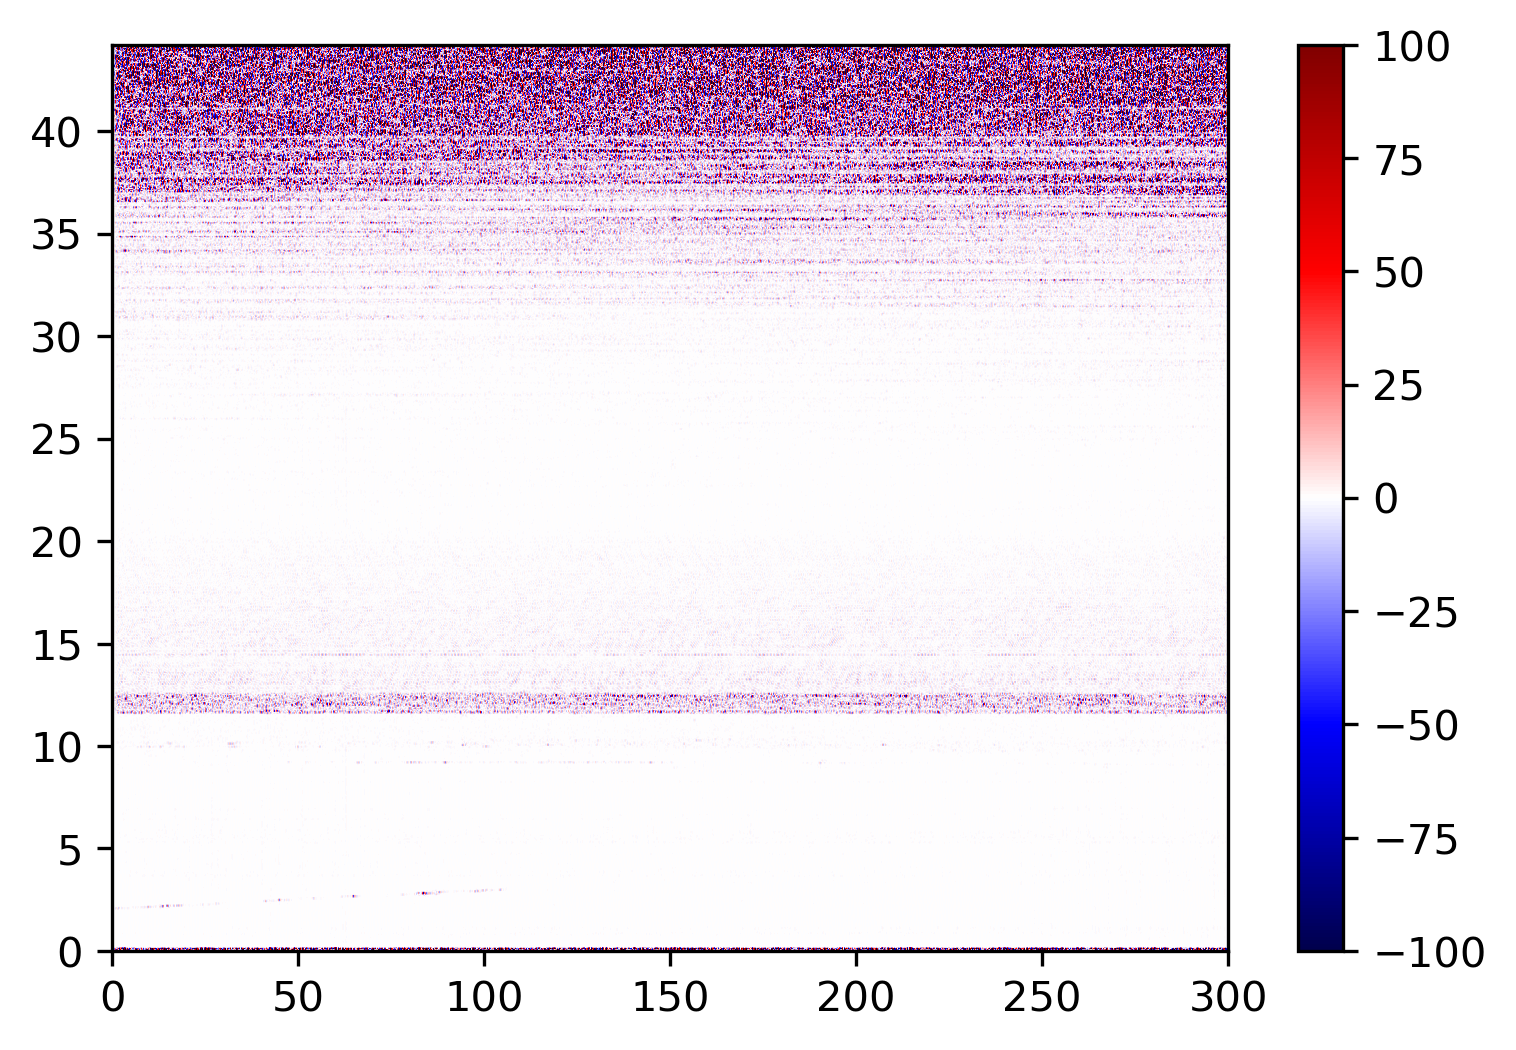

In [39]:
d = detrend(d)
d = taper(d, taper_fraction)
d = block_bandpass(d.T, freq_low, freq_high, fs)
#d = chebychev_lowpass_downsamp(d, fs, decimate_factor1)
#fs /= decimate_factor1
#d = chebychev_lowpass_downsamp(d, fs, decimate_factor2)
#fs /= decimate_factor2
d = d.T

d_check = d.copy()


fig = plt.figure(dpi=300)
im = plt.imshow(d, cmap='seismic', aspect='auto', origin='lower', extent=(0, (t1-t0).seconds, d_start/1000, d_end/1000), vmin=-100, vmax=100)
fig.colorbar(im)
plt.show()

### sta lta

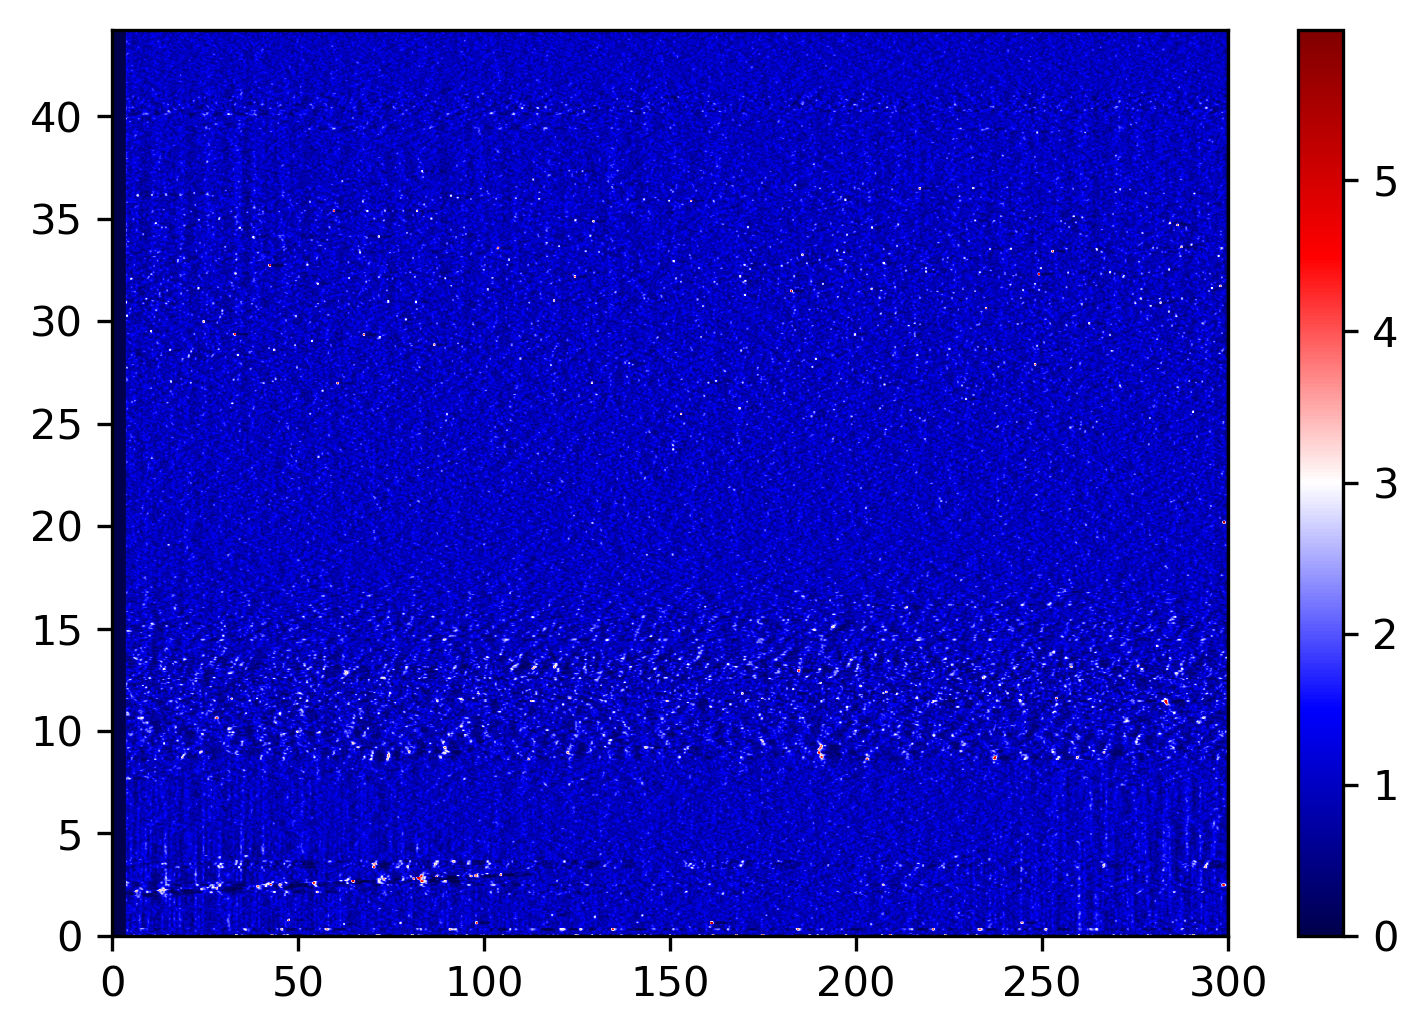

In [29]:
d = sta_lta(d, sta, lta)


fig = plt.figure(dpi=300)
im = plt.imshow(d, cmap='seismic', aspect='auto', origin='lower', extent=(0, (t1-t0).seconds, d_start/1000, d_end/1000))
fig.colorbar(im)
plt.show()

#d = cft.copy()



### Thresholding



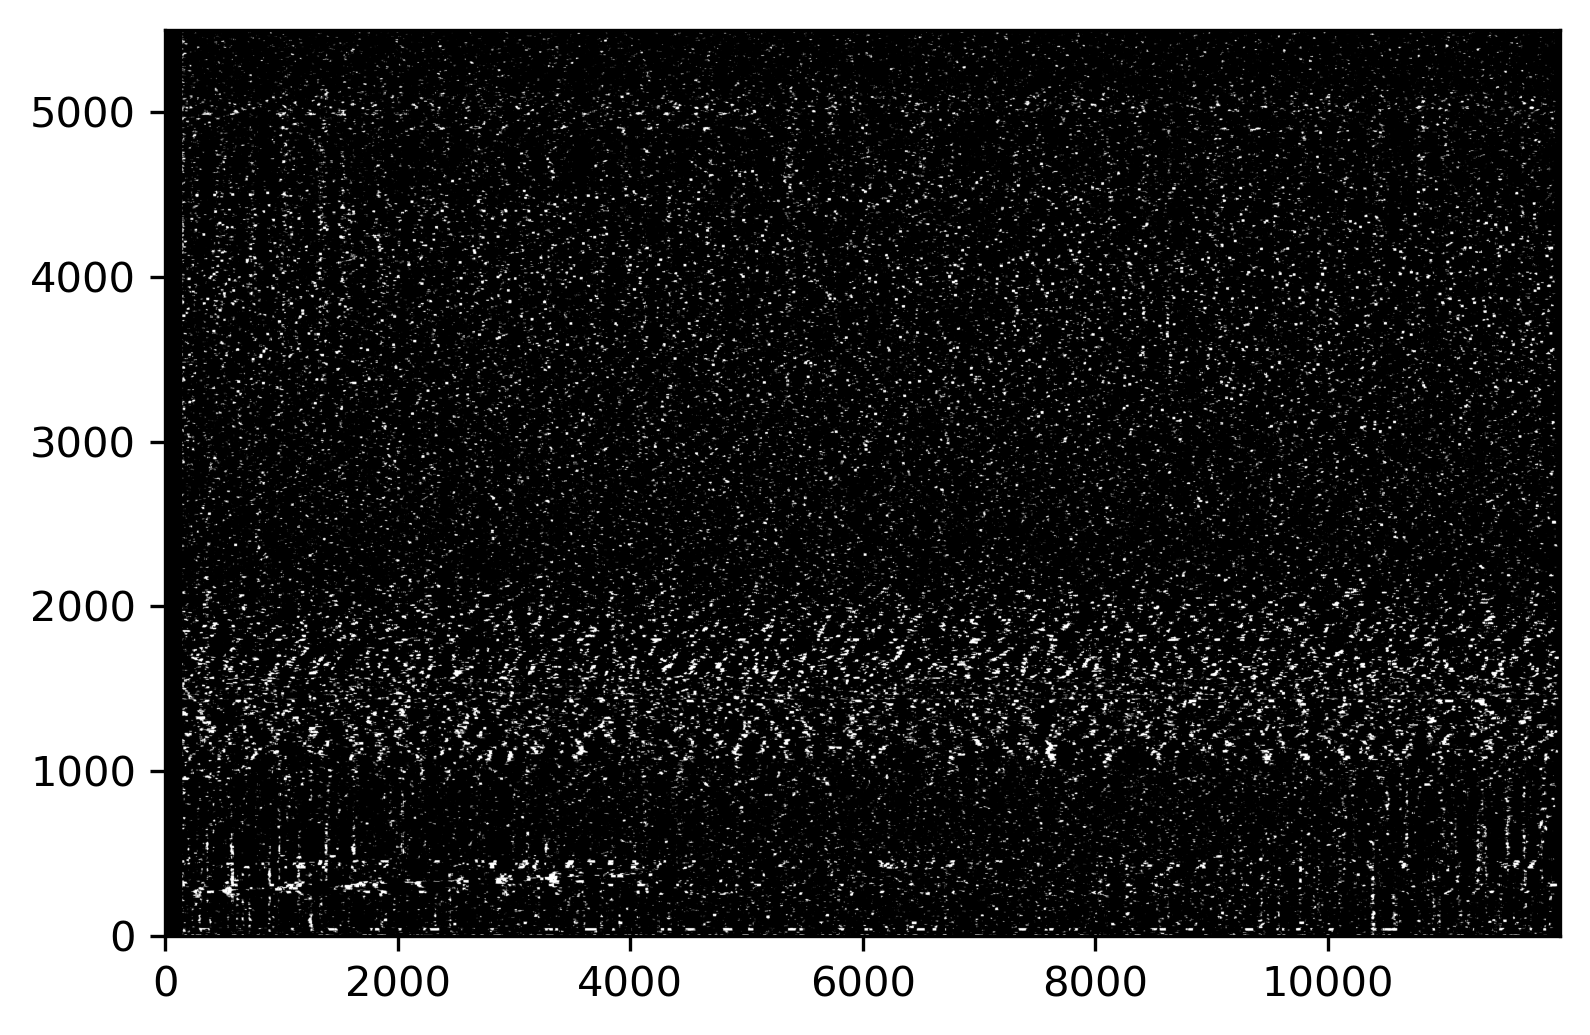

In [30]:
d = threshold(d)

    
fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

### remove small clusters

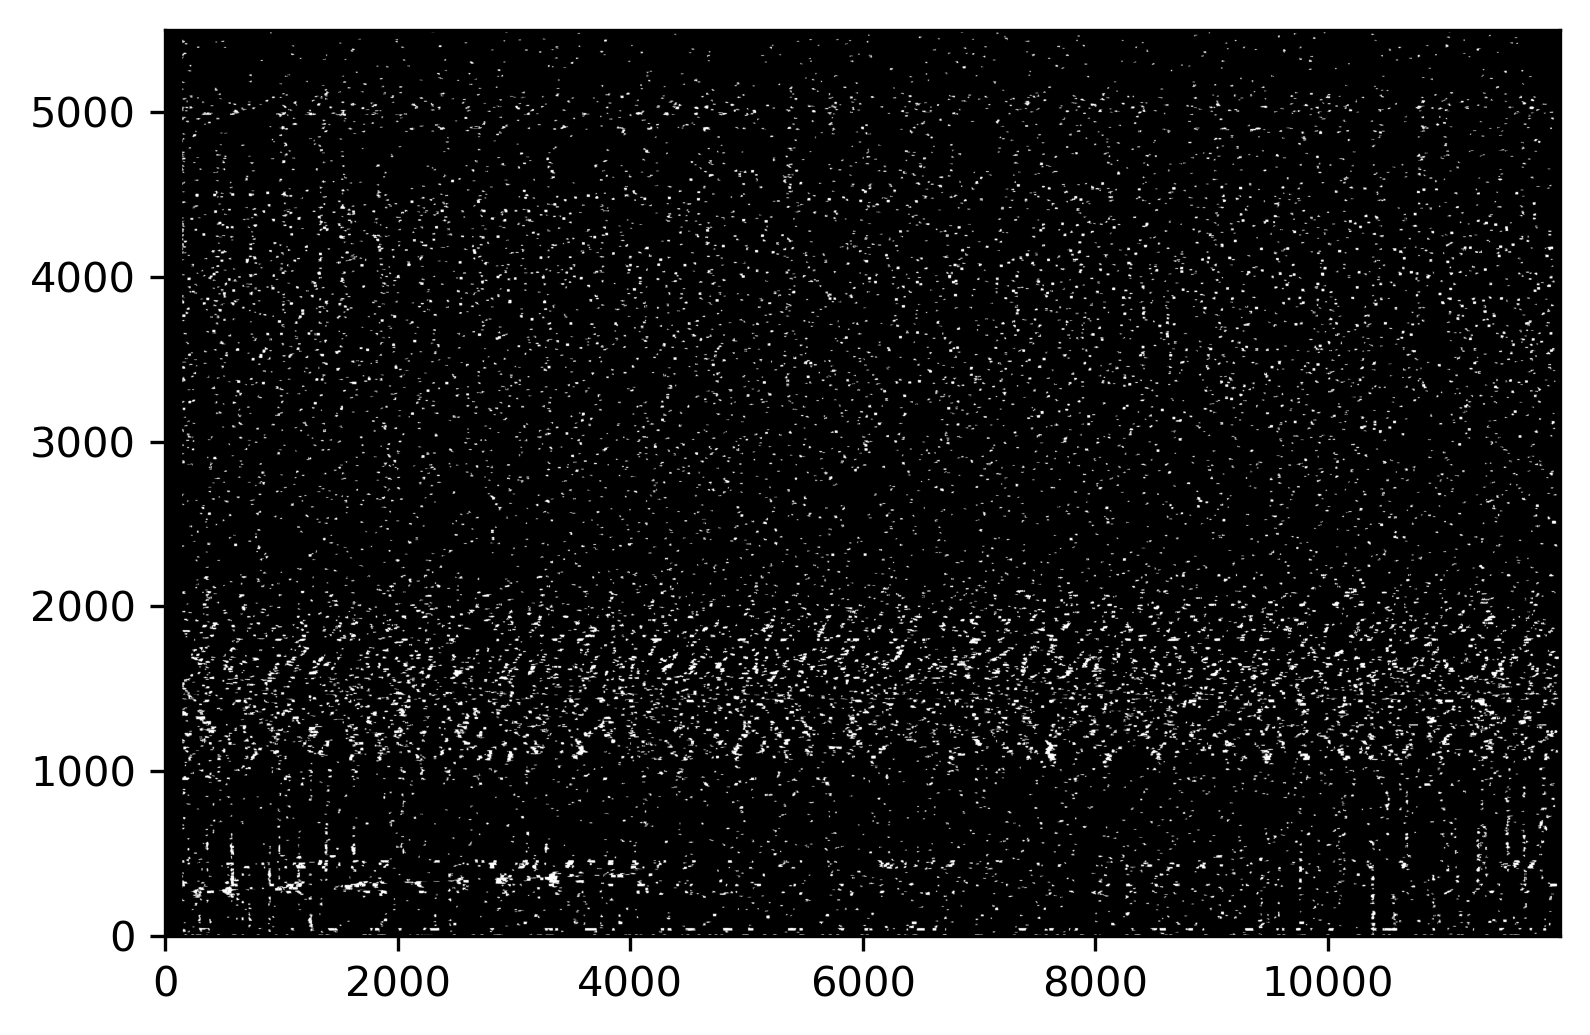

In [31]:
d = remove_small_objects(d.astype(bool), min_size=cluster_size1)

fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

### Remove horizontal lines

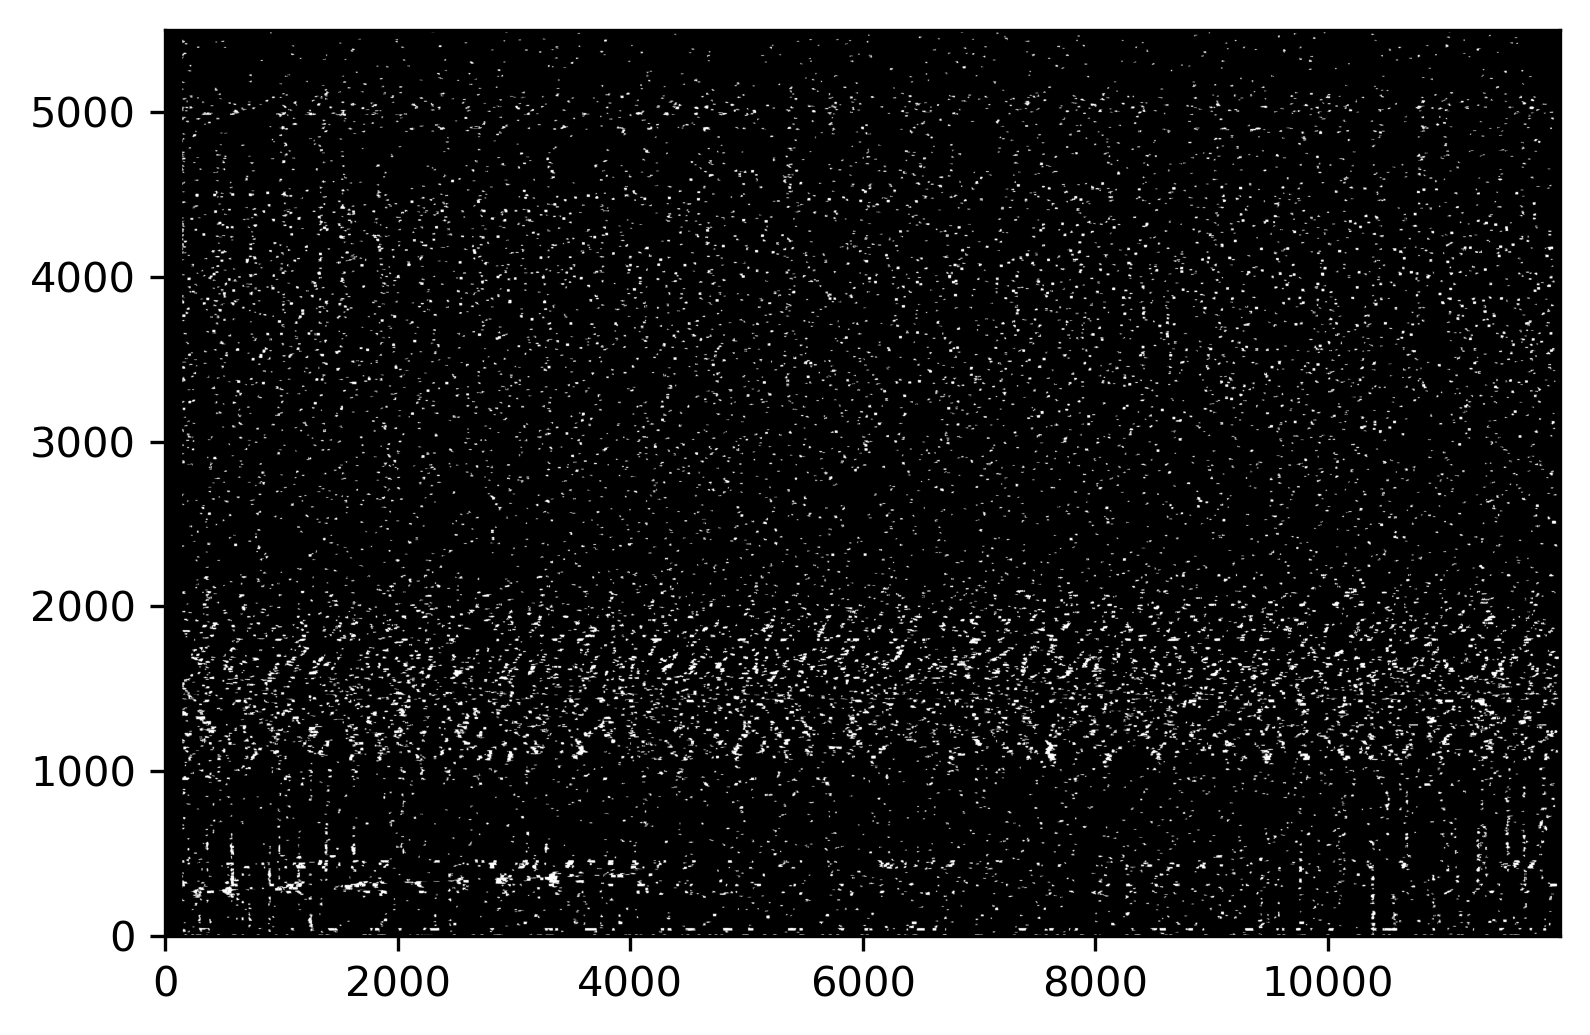

In [32]:
d = remove_horizontal_lines(kernel_horizontal, image=d.astype(bool))

fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

### Remove vertical lines

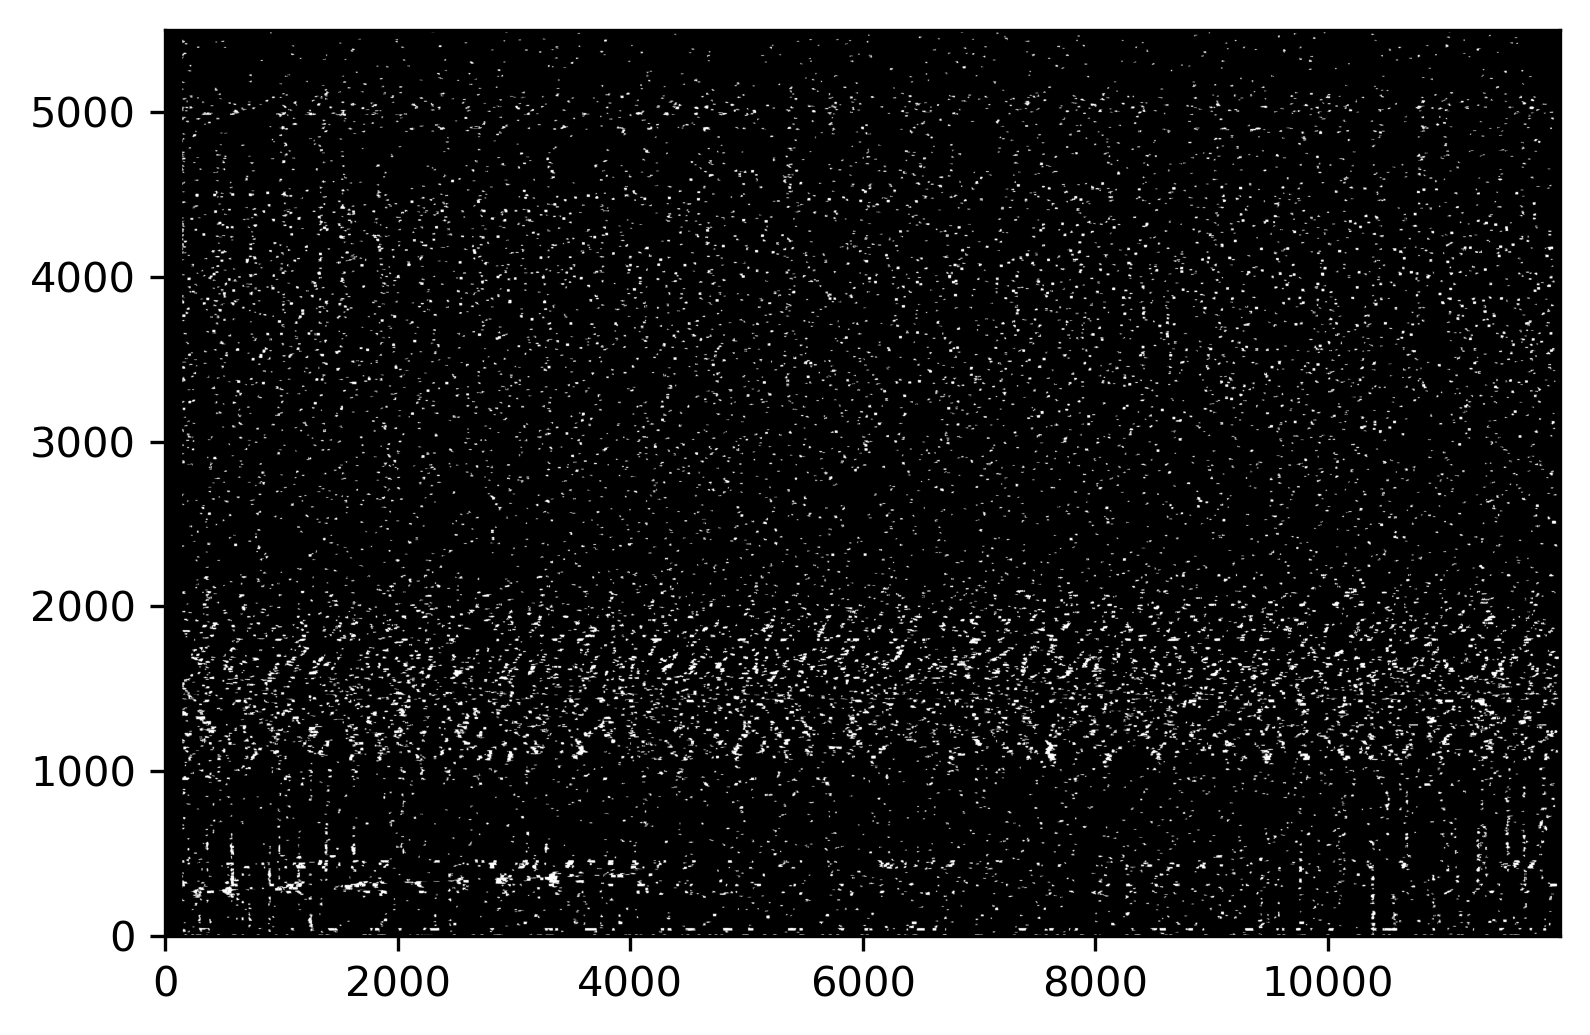

In [33]:
d = remove_vertical_lines(kernel_vertical, image=d.astype(bool))

fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

### keep diagonal lines

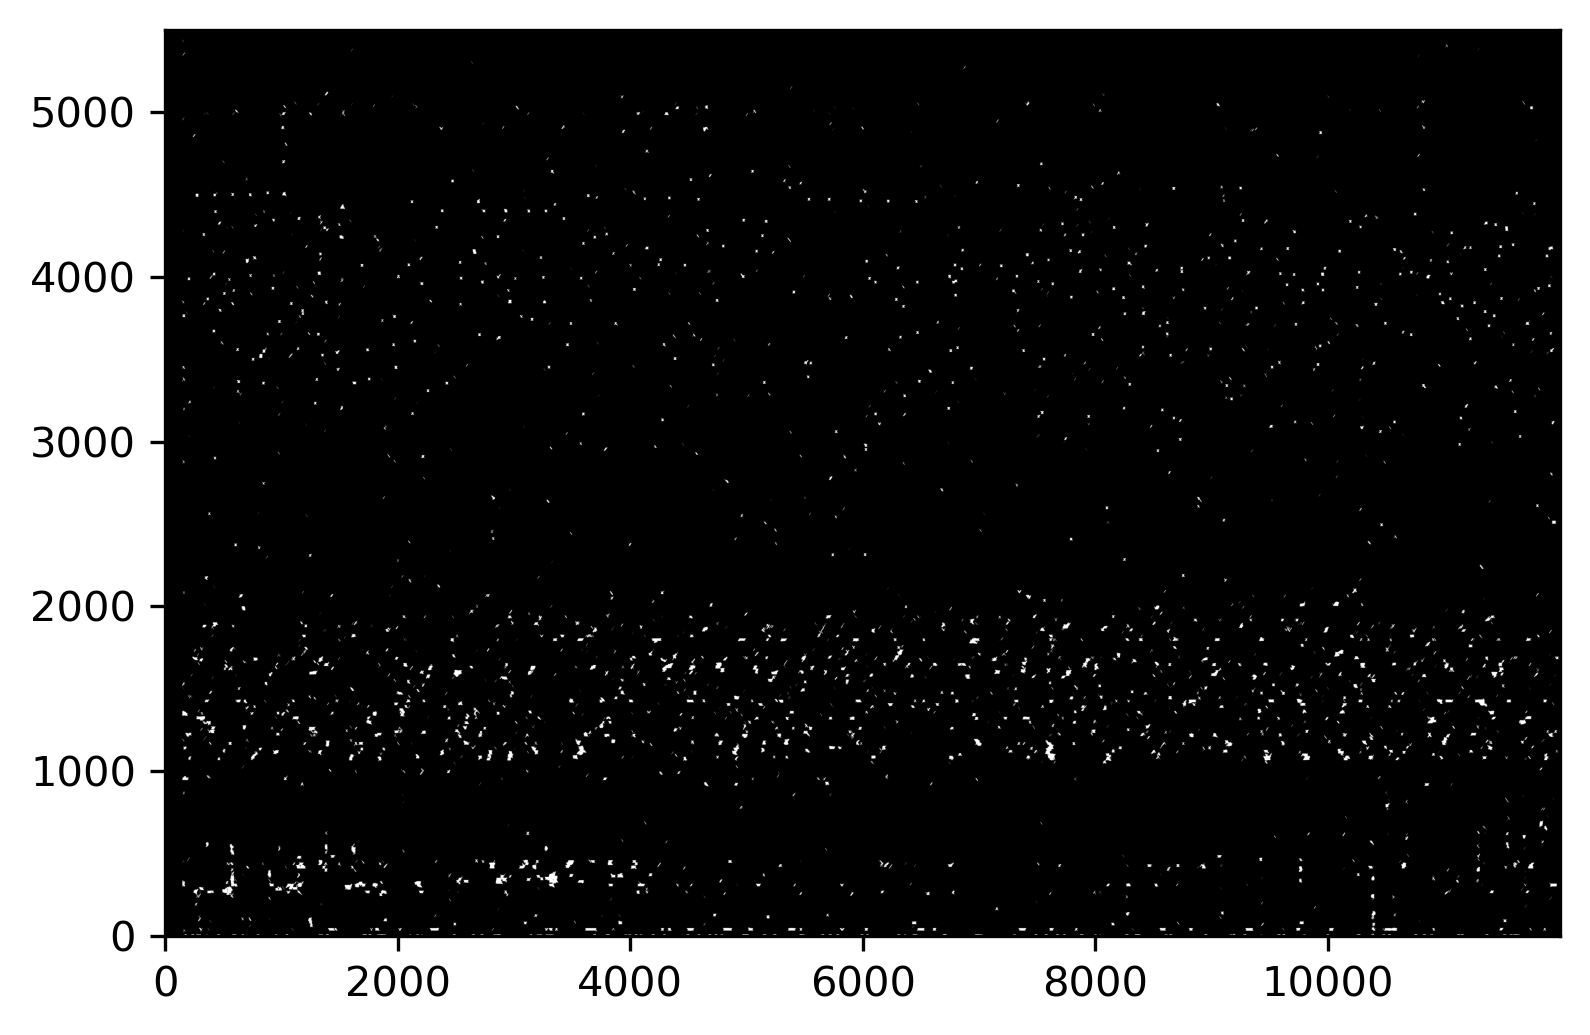

In [34]:
d = diagonal_lines(kernel_diagonal, image=d.astype(bool))


fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

### Remove small objects

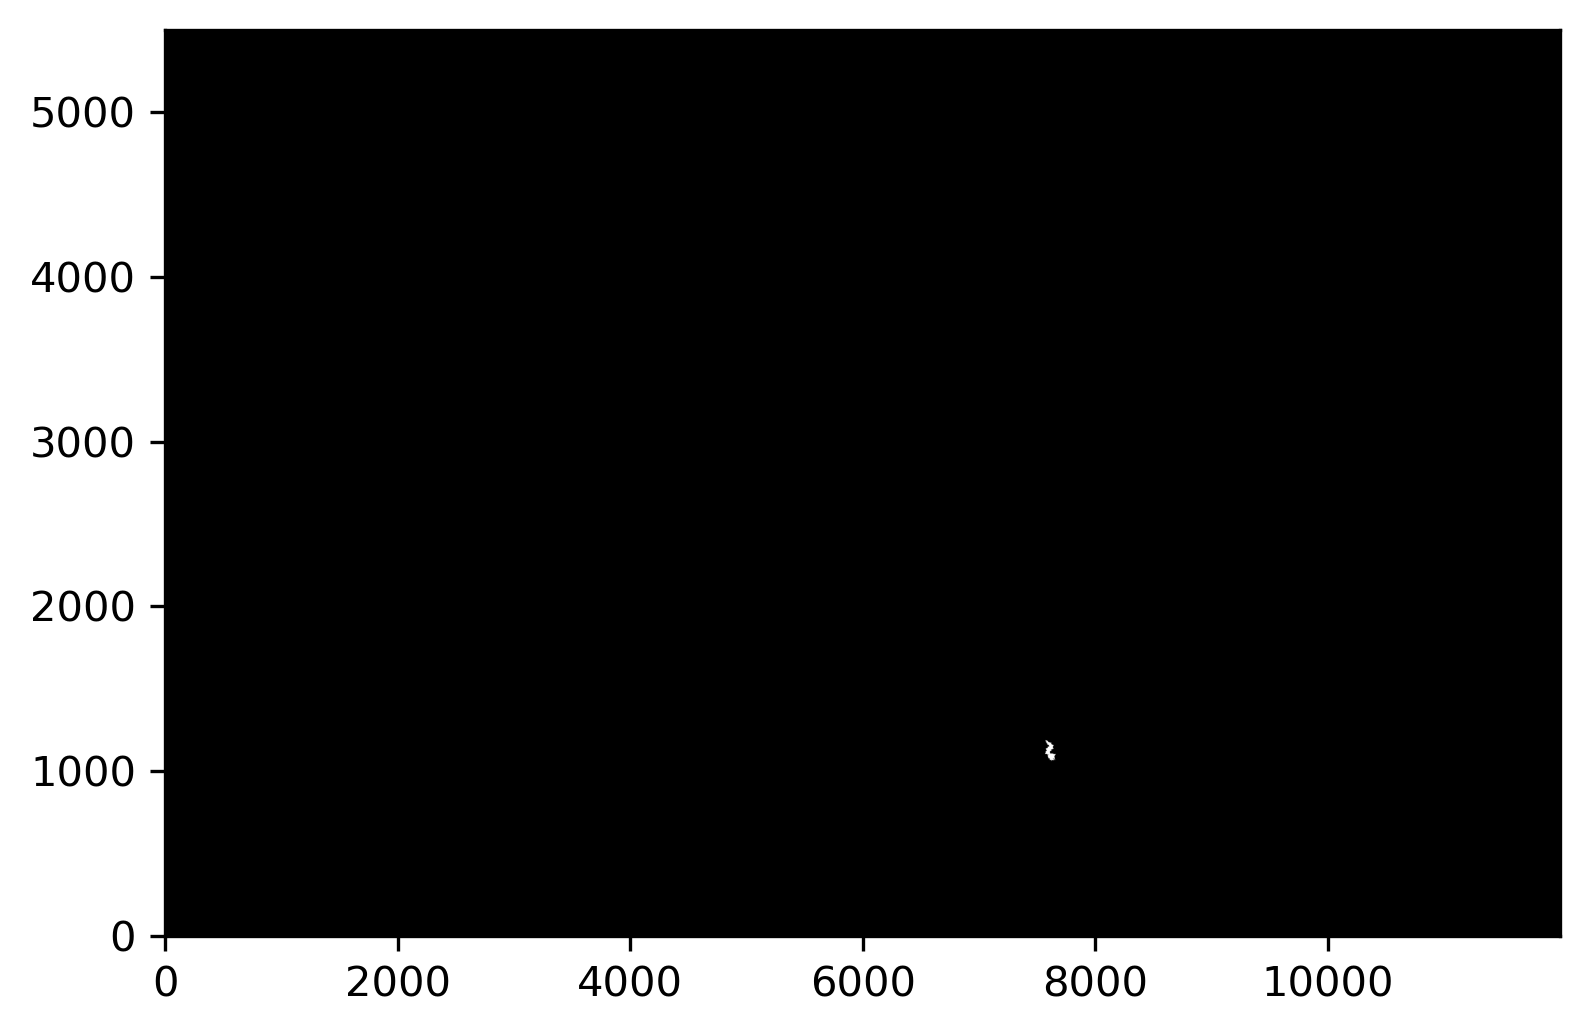

In [35]:
d = remove_small_objects(d.astype(bool), min_size=cluster_size2)

fig = plt.figure(dpi=300)
plt.imshow(d, cmap='gray', aspect='auto', origin='lower')
plt.show()

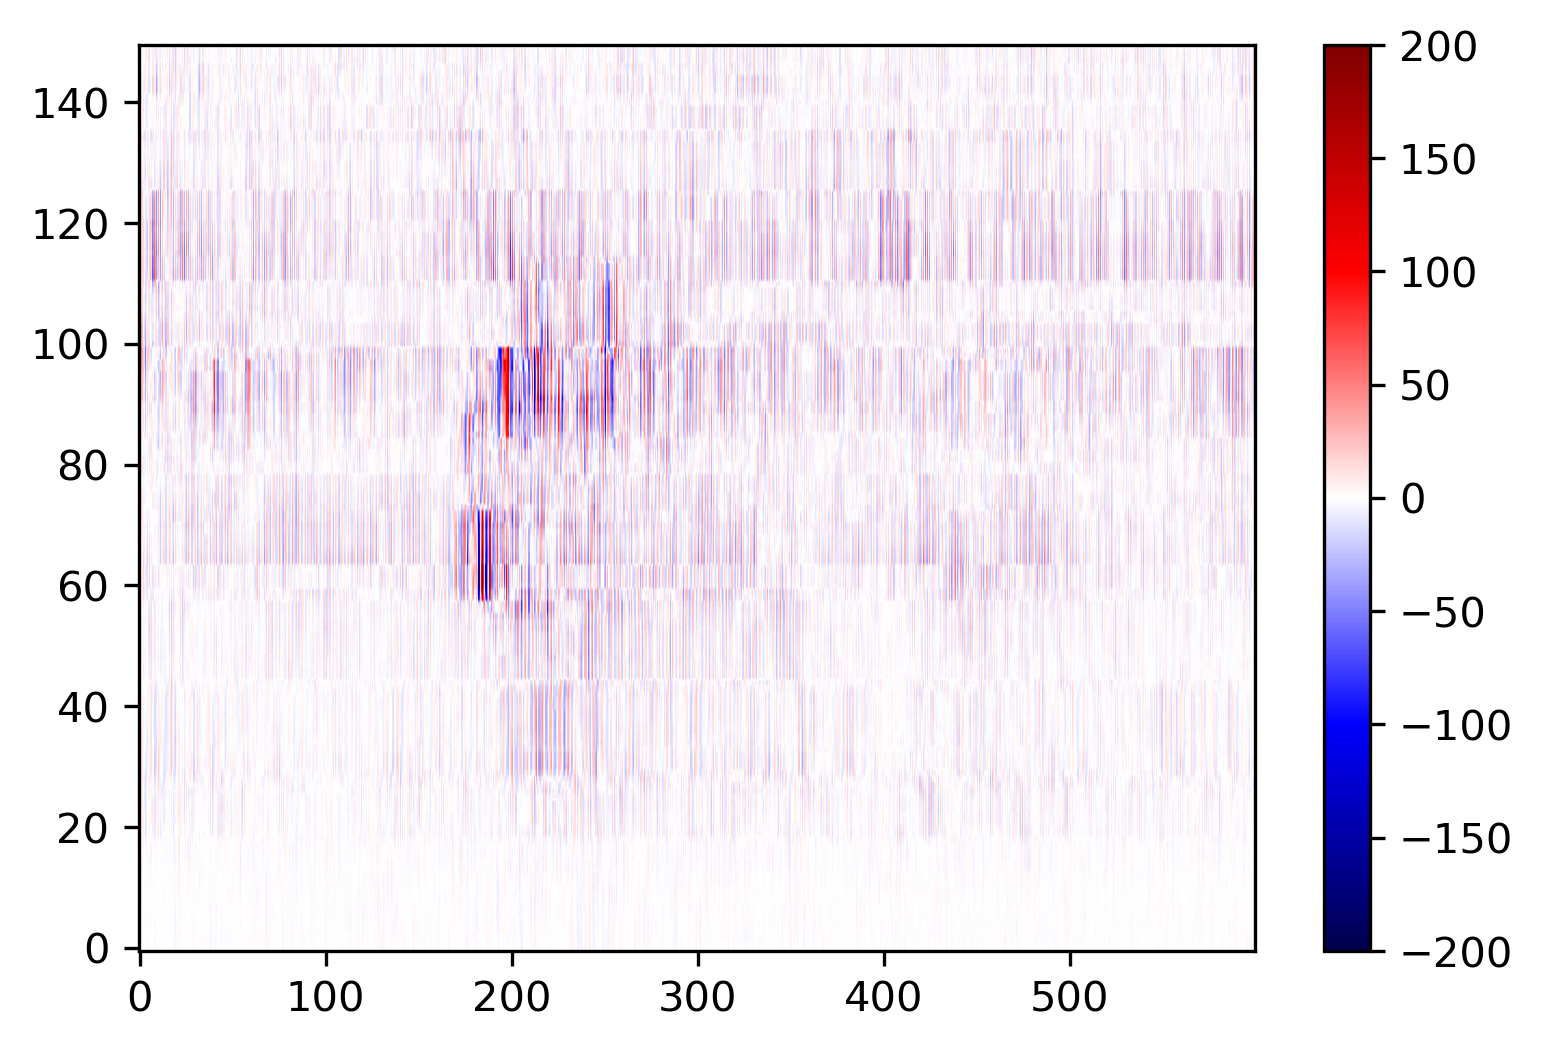

In [47]:
fig = plt.figure(dpi=300)
im = plt.imshow(d[1050:1200, 7400:8000], cmap='seismic', aspect='auto', origin='lower', vmin=-200, vmax=200)
fig.colorbar(im)
plt.show()